In [4]:
# import warnings
# warnings.filterwarnings('ignore')
import numpy as np
# np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# import sklearn
# from sklearn import svm
from sklearn.svm import SVC
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
import time
from sklearn import preprocessing
import csv
import time

In [5]:
%cd "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/Esr1_3/svm/"
data=pd.read_excel('/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/Esr1_3/svm/metadata.xlsx')

/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/Esr1_3/svm


In [6]:
data

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,stim,percent.mito,integrated_snn_res.0.8,seurat_clusters,celltype,conditiontype,...,Ctnna2,Napb,Ywhag,Id4,Dynll2,Eif4g2,Grik1,mt-Nd4l,group,Condition
0,TGGCCAGAGCCACTATP23M,10X_MPOA,1398,952,P23M,0.070815,3,3,Vgat2,P23MVgat2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,P23M,immature
1,CCGTTCAAGGGTATCGP23M,10X_MPOA,4886,2607,P23M,0.028039,5,5,Vgat4,P23MVgat4,...,0.000000,2.586258,2.418884,1.114047,1.965712,0.000000,0.000000,1.114047,P23M,immature
2,TTCCCAGAGGAATTACP23M,10X_MPOA,4302,2196,P23M,0.035797,5,5,Vgat4,P23MVgat4,...,0.000000,0.000000,2.076124,0.000000,2.535481,0.000000,0.000000,0.000000,P23M,immature
3,AAACGGGCACCACGTGP23M,10X_MPOA,4257,2287,P23M,0.050035,5,5,Vgat4,P23MVgat4,...,0.000000,0.000000,1.208683,1.208683,2.085326,1.740141,0.000000,1.740141,P23M,immature
4,AAGTCTGGTCTAGAGGP23M,10X_MPOA,3236,1897,P23M,0.046044,5,5,Vgat4,P23MVgat4,...,1.408602,1.971365,1.971365,2.329296,2.329296,0.000000,0.000000,0.000000,P23M,immature
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,CTCAGAAGTCTGCCAGCast,10X_MPOA,8105,3445,Cast,0.031709,3,3,Vgat2,CastVgat2,...,0.803707,2.265573,2.128569,0.000000,2.679093,1.547864,0.000000,0.000000,Cast,immature
1036,GAGGTGAAGAAGATTCCast,10X_MPOA,7613,3179,Cast,0.052804,3,3,Vgat2,CastVgat2,...,0.000000,2.648684,2.023891,0.000000,2.443072,0.000000,1.597492,1.288429,Cast,immature
1037,GGAACTTGTCTAGCGCCast,10X_MPOA,12505,4470,Cast,0.051419,3,3,Vgat2,CastVgat2,...,1.434780,2.501069,2.564580,0.587609,2.360492,1.757527,0.000000,1.609118,Cast,immature
1038,CCACGGAGTATAAACGCast,10X_MPOA,5326,2574,Cast,0.047315,5,5,Vgat4,CastVgat4,...,1.056950,2.141280,1.892019,0.000000,1.559231,1.892019,0.000000,0.000000,Cast,immature


In [40]:
##Use SVM to classify data ###
def ephys_svm(filename,predict,params,iterations,test_data,df):
    parameters = [{'C': [.001,.01,.1,1,10,100,1000], 'kernel': ['linear']},
                  {'C': [.001,.01,.1,1,10,100,1000], 'gamma': [.001,.01,.1,1,10,100,1000], 'kernel': ['rbf']}]  
#     df=summarydata[summarydata.label != label_tag]

    ##normalize columns (except for 'predict' column)##
    df_norm=df[params]
    df_predict=df[predict]
    df_norm=pd.DataFrame(preprocessing.scale(df_norm))
    df_predict.reset_index(drop=True, inplace=True)
    df_norm.reset_index(drop=True, inplace=True)
    df=pd.concat([df_norm,df_predict],axis=1)
    df=df.dropna()
    headers=params+predict
    df.columns=headers

#     combined=params+predict
#     df=df[combined].dropna()
    
    pred_score=np.nan*np.zeros((iterations))
    rand_score=np.nan*np.zeros((iterations))
    for i in range(iterations):
        print ('\nRun #: ', i+1)
        ## if splits result in insufficient data to classify, skip run and move on ##
        try:
            ##randomly subset df into test and train sets
            msk = np.random.rand(len(df))>test_data
            train = df[msk]
            ##use gridsearch to select optimal parameters for each run
            clf = GridSearchCV(SVC(), parameters,cv=10,n_jobs=-1,iid=False)
            train_labels=train[predict].values
            c,r=train_labels.shape
            train_labels=train_labels.reshape(c,)
            clf.fit(train[params], train_labels)
            print ('prediction accuracy = ', clf.best_score_)
            pred_score[i]=(clf.best_score_)*100
            ##random array of 1s and 0s for testing classifier
            rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
            clf.fit(train[params], rand_group[0])
            print ('shuffled accuracy = ', clf.best_score_)
            rand_score[i]=(clf.best_score_)*100
        except Exception:
            pass
    plt.figure(figsize=(5,5))
    ax=plt.subplot(111)
    n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score))
    Xs = np.sort(pred_score)
    plt.step(Xs,n,color='g',label='Model prediction',alpha=0.7,linewidth=2)
    n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score))
    Xs2= np.sort(rand_score)
    plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)
#     ax.set_axis_bgcolor('white')
    plt.xlabel('Decoding accuracy %',fontsize=14)
    plt.ylabel('Proportion of runs',fontsize=14)
    plt.legend(fontsize=14,loc=2)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    plt.savefig(filename+'_'+timestr+'_'+str(iterations)+str('iter_')+str(test_data)+'test_data_prediction_accuracy_CDF.pdf')
    np.savetxt(filename+'_'+timestr+'_'+str(iterations)+str('iter_')+str(test_data)+'_prediction_accuracy.csv',pred_score,delimiter=',')
    np.savetxt(filename+'_'+timestr+'_'+str(iterations)+str('iter_')+str(test_data)+'_RANDOM_prediction_accuracy.csv',rand_score,delimiter=',')
    plt.show()
    
    #save parameters to csv
    master_parameters=['Classify on '+ str(params), '\nPredict '+str(predict), '\nCells used = '+str(condition[0]),
               '\nIterations = '+str(iterations), '\nProportion test data = '+str(test_data), 
                '\nSearch Parameters = '+str(parameters)]
    with open(filename+'_'+timestr+'_parameters','w') as myfile: # it was wb
        out=csv.writer(myfile,delimiter=' ')
        out.writerow(master_parameters)
    print ("mean decoding accuracy = ", np.nanmean(pred_score))
    print ("mean RANDOM decoding accuracy = ",np.nanmean(rand_score))
#     return pred_score,rand_score

In [7]:
np.array(data.columns[10:50]).tolist()

['Eef1a2',
 'mt-Co2',
 'mt-Atp6',
 'Pgr',
 'Ptp4a1',
 'mt-Nd1',
 'Itm2c',
 'Prkce',
 'Cntnap2',
 'Maged1',
 'Irs4',
 'Lamp5',
 '1500009L16Rik',
 'Gm10076',
 'Actg1',
 'Parm1',
 'Ube2m',
 'Greb1',
 'Ogfrl1',
 'Pak3',
 'Calm3',
 'Mt3',
 'Tmsb10',
 'Socs2',
 'mt-Cytb',
 'Apoc3',
 'Sez6l',
 'mt-Co1',
 'mt-Nd4',
 'Hpcal1',
 'mt-Co3',
 'mt-Nd2',
 'Ctnna2',
 'Napb',
 'Ywhag',
 'Id4',
 'Dynll2',
 'Eif4g2',
 'Grik1',
 'mt-Nd4l']


Run #:  1


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9431790123456789


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5055555555555555

Run #:  2


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9314814814814815


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5397922312556458

Run #:  3


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9330737584484279


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5267411107846017

Run #:  4


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9414500683994527


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5123119015047879

Run #:  5


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9329268292682927


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5219512195121951

Run #:  6


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9341078600114745


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5286144578313253

Run #:  7


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9396358543417366


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5349999999999999

Run #:  8


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9330884513664414


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5341022627093741

Run #:  9


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9309996988858777


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5338753387533876

Run #:  10


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9317073170731707


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5280487804878049

Run #:  11


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.932037037037037


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.513611111111111

Run #:  12


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9394936708860759


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5491455696202532

Run #:  13


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9380711354309165


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5343912448700411

Run #:  14


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9416666666666668


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5011904761904762

Run #:  15


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9358403361344537


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5273529411764706

Run #:  16


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.92796918767507


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5473109243697479

Run #:  17


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9383769948810601


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5228545618789522

Run #:  18


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9347478991596638


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5190056022408964

Run #:  19


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9392857142857143


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5428571428571429

Run #:  20


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9362541403191811


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5127521830773863

Run #:  21


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9329562151043197


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5225389362327358

Run #:  22


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9397443432265649


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5488833382309727

Run #:  23


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9417278871583896


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5177637378783426

Run #:  24


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.929432013769363


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5257171543316121

Run #:  25


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9278112449799197


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5330895008605852

Run #:  26


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9359094916250367


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.515133705553923

Run #:  27


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9323978842198061


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5434322656479577

Run #:  28


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9347338935574229


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5261204481792716

Run #:  29


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.934495123350545


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5256024096385542

Run #:  30


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9256454388984509


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5378370625358577

Run #:  31


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9436251709986321


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5241176470588235

Run #:  32


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9341939185312679


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5169391853126792

Run #:  33


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9386274509803922


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5395378151260504

Run #:  34


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9337535014005602


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5129831932773109

Run #:  35


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9269607843137255


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5176890756302521

Run #:  36


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.93696738172201


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5280047017337643

Run #:  37


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9408611863896418


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5098464317976512

Run #:  38


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9342082616179


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5053930005737235

Run #:  39


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9390849110728627


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5053786574870912

Run #:  40


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9401462994836489


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5434882386689615

Run #:  41


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9337247816922613


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5288919000301113

Run #:  42


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9352661064425771


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5111904761904762

Run #:  43


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9321334116955626


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5485600940346752

Run #:  44


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9414084911072862


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5317555938037865

Run #:  45


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9452101087275931


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5140023508668821

Run #:  46


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9271296296296295


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5055555555555555

Run #:  47


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9351979345955248


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5024096385542169

Run #:  48


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9258154569497503


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5375844842785777

Run #:  49


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9313760915386933


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5222372779283349

Run #:  50


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9375358577165805


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5036144578313253

Run #:  51


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9326592082616179


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5066121629374642

Run #:  52


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9462707974756167


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5125502008032129

Run #:  53


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.93644578313253


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5534136546184738

Run #:  54


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9392300910960918


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5133705553923008

Run #:  55


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9354561101549053


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5370195065978198

Run #:  56


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9300910960916837


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.541625036732295

Run #:  57


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9356425702811244


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5407917383820997

Run #:  58


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9438873833182775


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.509153869316471

Run #:  59


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9346165148398471


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5158830443726125

Run #:  60


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9357983193277312


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5410784313725491

Run #:  61


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9430252100840335


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.503641456582633

Run #:  62


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9451954158095799


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5335586247428739

Run #:  63


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9286071113723185


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.526006464883926

Run #:  64


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9327022375215146


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5338209982788296

Run #:  65


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9325210084033614


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.55093837535014

Run #:  66


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9383544303797468


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5193354430379747

Run #:  67


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9385395239494564


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.513855421686747

Run #:  68


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9374284853959651


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5269497139415839

Run #:  69


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.931764705882353


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5552941176470589

Run #:  70


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9273288275051425


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5127240669997061

Run #:  71


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9377428180574554


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5099863201094391

Run #:  72


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9353206865401988


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.520189701897019

Run #:  73


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.935608755129959


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5076060191518468

Run #:  74


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.941508892713712


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5341222030981068

Run #:  75


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9361336946702801


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5485094850948509

Run #:  76


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9390697674418604


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5411491108071135

Run #:  77


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.925668527769615


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.531060828680576

Run #:  78


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9411503155479058


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5084050487664945

Run #:  79


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9375037639265281


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5141222523336344

Run #:  80


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9298266235674406


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5206435498089921

Run #:  81


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9442717086834733


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5124089635854341

Run #:  82


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9356569133677567


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5095381526104418

Run #:  83


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.928298909925416


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5346242111302353

Run #:  84


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9342512908777969


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5358864027538728

Run #:  85


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9331612162937464


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5209839357429719

Run #:  86


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9364744693057945


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5155765920826162

Run #:  87


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9322950337937114


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.521863062004114

Run #:  88


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9366322432587492


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5125788869764774

Run #:  89


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9338095238095239


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5100700280112045

Run #:  90


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9385248310314427


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5439905965324714

Run #:  91


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.942859097127223


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5286183310533515

Run #:  92


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.945166379804934


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5143144004589788

Run #:  93


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9400172117039587


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5211130235226621

Run #:  94


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9334410813987659


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5140758154569498

Run #:  95


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9330464716006883


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5527682157200229

Run #:  96


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9375350140056021


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5164985994397759

Run #:  97


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9308376362593229


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5155192197360872

Run #:  98


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9445489274169852


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5343814281516309

Run #:  99


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9317412507171543


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5408921399885256

Run #:  100


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.9344377510040159
shuffled accuracy =  0.5202380952380952


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


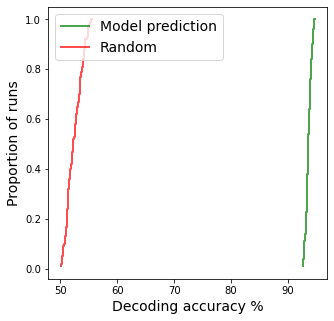

mean decoding accuracy =  93.57557902362772
mean RANDOM decoding accuracy =  52.50112045423798
22774.232835292816


In [41]:
## set SVM params, choose params to classify on, and subset cells ##

#### EDIT THIS ####
filename='TEST'
predict=['Condition'] ## variable to classify (e.g. projection, group, condition)
condition=['All Cells'] ## only used for reference in parameter file
params=np.array(data.columns[10:50]).tolist()## choose params to use for classification 

summarydata=pd.DataFrame(data)
summarydata=summarydata.replace(['mature','immature'],[1,0])
#summarydata=summarydata.replace(['ad lib','fasted'],[0,1])
# label_tag=1  ## Choose 1 for ad lib and 0 for fasted; or 1 for VTA and 0 for LHb ##

# df=summarydata[summarydata.projection == 1]  #change param as input data
df=summarydata

iterations=100
test_data=.2  #defines split for test/train sets
#####

### Run SVM for eYFP+ cells to predict group based on rheo and max latency ###
start = time.time()
ephys_svm(filename,predict,params,iterations,test_data,df)
end = time.time()
print(end - start)

# Vgat low

In [35]:
%cd "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/low/svm/"
data=pd.read_excel('/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/low/svm/metadata.xlsx')

/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/low/svm



Run #:  1


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7319806763285024


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.528792270531401

Run #:  2


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7147463002114165


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5573467230443975

Run #:  3


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7219696969696969


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5396969696969697

Run #:  4


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7419158361018827


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5245293466223699

Run #:  5


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.717718715393134


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.55

Run #:  6


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7298067632850241


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5353623188405796

Run #:  7


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7136892177589852


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5166490486257928

Run #:  8


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.713953488372093


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5093023255813953

Run #:  9


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7445560253699789


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5648520084566596

Run #:  10


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7188383838383838


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5518181818181818

Run #:  11


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7302898550724638


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5230434782608696

Run #:  12


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7295454545454545


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.509090909090909

Run #:  13


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7167828106852496


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5237514518002323

Run #:  14


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7282392026578073


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5565891472868216

Run #:  15


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.751955602536998


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5578752642706132

Run #:  16


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7482323232323234


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5215656565656566

Run #:  17


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.717718715393134


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5245293466223699

Run #:  18


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7380676328502416


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5322222222222222

Run #:  19


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7255813953488373


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5372093023255814

Run #:  20


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7536714975845411


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5102415458937198

Run #:  21


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7296511627906976


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5023255813953489

Run #:  22


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7627906976744188


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5255813953488373

Run #:  23


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7532668881506092


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5249723145071983

Run #:  24


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7264799154334038


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5171247357293869

Run #:  25


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7284355179704017


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.55

Run #:  26


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7145625692137321


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5500553709856035

Run #:  27


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7528792912513842


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5037098560354375

Run #:  28


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7310101010101011


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5349999999999999

Run #:  29


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7381642512077294


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5166183574879227

Run #:  30


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7449275362318841


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5322705314009661

Run #:  31


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7257575757575758


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.534040404040404

Run #:  32


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7117874396135265


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5297101449275362

Run #:  33


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7143763213530656


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5298097251585624

Run #:  34


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7122369878183832


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.553156146179402

Run #:  35


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.741140642303433


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5503322259136213

Run #:  36


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7226215644820296


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5497885835095138

Run #:  37


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7121256038647343


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5421256038647343

Run #:  38


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.744186046511628


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5441860465116279

Run #:  39


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7348989898989899


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5168181818181817

Run #:  40


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7322222222222222


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5335353535353535

Run #:  41


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7272978959025471


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5387043189368771

Run #:  42


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7403535353535353


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5969696969696969

Run #:  43


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7347729789590256


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5316722037652271

Run #:  44


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7123232323232324


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5181313131313131

Run #:  45


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7405919661733615


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5138477801268498

Run #:  46


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7254040404040404


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5486868686868686

Run #:  47


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7196566998892581


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5191029900332226

Run #:  48


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7221458773784356


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5215116279069767

Run #:  49


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7277272727272727


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5488383838383838

Run #:  50


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7380398671096347


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5481727574750831

Run #:  51


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7301449275362318


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5338647342995169

Run #:  52


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7433403805496829


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5552854122621566

Run #:  53


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7110606060606061


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5521212121212121

Run #:  54


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7205050505050505


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5178282828282827

Run #:  55


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7541226215644821


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5509513742071881

Run #:  56


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7302525252525253


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5542424242424242

Run #:  57


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7484343434343435


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5226262626262625

Run #:  58


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7425757575757577


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5417171717171716

Run #:  59


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7307575757575757


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5187878787878788

Run #:  60


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7368181818181817


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5694444444444444

Run #:  61


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7297568710359409


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5319767441860466

Run #:  62


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7318181818181818


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5363636363636364

Run #:  63


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7240909090909091


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5141919191919192

Run #:  64


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7275757575757575


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5411616161616161

Run #:  65


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7436363636363638


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5171717171717172

Run #:  66


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.740909090909091


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5409090909090909

Run #:  67


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.748678646934461


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5313424947145877

Run #:  68


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7353820598006645


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5280177187153932

Run #:  69


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7241414141414142


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5078787878787879

Run #:  70


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7255813953488373


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5162790697674419

Run #:  71


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7427061310782241


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5254228329809726

Run #:  72


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7107575757575757


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5124242424242424

Run #:  73


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7242600422832981


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5284355179704017

Run #:  74


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7187153931339978


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5306201550387597

Run #:  75


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7413847780126851


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5433932346723045

Run #:  76


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7376849894291755


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5801797040169133

Run #:  77


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7525757575757577


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5419696969696969

Run #:  78


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7395348837209303


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5558139534883721

Run #:  79


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7427589852008457


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.528646934460888

Run #:  80


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.724524312896406


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5193446088794926

Run #:  81


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7276955602536999


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5435517970401691

Run #:  82


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7094949494949495


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5144444444444444

Run #:  83


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7359420289855072


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5476811594202898

Run #:  84


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7316596194503171


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.501215644820296

Run #:  85


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7388704318936876


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5185492801771872

Run #:  86


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7240486257928118


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5577167019027485

Run #:  87


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7219344608879493


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5856236786469344

Run #:  88


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7481313131313131


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5487373737373737

Run #:  89


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7428017718715393


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5058139534883721

Run #:  90


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7265217391304348


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5371014492753623

Run #:  91


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7305050505050505


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5113131313131312

Run #:  92


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.741919191919192


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5276767676767675

Run #:  93


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7400105708245243


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5307610993657506

Run #:  94


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7244186046511628


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5212624584717608

Run #:  95


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7399778516057587


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5281284606866002

Run #:  96


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7367171717171718


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5248484848484848

Run #:  97


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7513636363636363


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5259090909090909

Run #:  98


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7273255813953489


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5620507399577168

Run #:  99


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7323995771670191


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5204545454545454

Run #:  100


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7210359408033827
shuffled accuracy =  0.5664376321353066


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


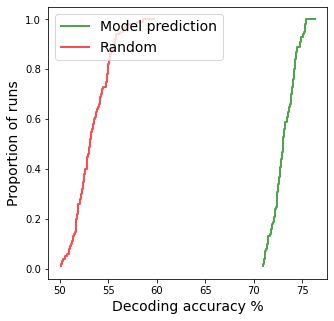

mean decoding accuracy =  73.17835347179586
mean RANDOM decoding accuracy =  53.42895678404803
28905.712169885635


In [36]:
## set SVM params, choose params to classify on, and subset cells ##

#### EDIT THIS ####
filename='TEST'
predict=['Condition'] ## variable to classify (e.g. projection, group, condition)
condition=['All Cells'] ## only used for reference in parameter file
params=np.array(data.columns[10:63]).tolist()## choose params to use for classification 

summarydata=pd.DataFrame(data)
summarydata=summarydata.replace(['mature','immature'],[1,0])
#summarydata=summarydata.replace(['ad lib','fasted'],[0,1])
# label_tag=1  ## Choose 1 for ad lib and 0 for fasted; or 1 for VTA and 0 for LHb ##

# df=summarydata[summarydata.projection == 1]  #change param as input data
df=summarydata

iterations=100
test_data=.2  #defines split for test/train sets
#####

### Run SVM for eYFP+ cells to predict group based on rheo and max latency ###
start = time.time()
ephys_svm(filename,predict,params,iterations,test_data,df)
end = time.time()
print(end - start)

# Vgat-Ar

In [37]:
%cd "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/Ar/svm/"
data=pd.read_excel('/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/Ar/svm/metadata.xlsx')

/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Trajectory/male/Ar/svm



Run #:  1


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7904040404040404
shuffled accuracy =  0.5050608122036694

Run #:  2


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8018370454978108
shuffled accuracy =  0.5282124500285551

Run #:  3


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7809999999999999


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.511979797979798

Run #:  4


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8
shuffled accuracy =  0.5214285714285715

Run #:  5


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7951980198019802


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5074554455445545

Run #:  6


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7956969696969697
shuffled accuracy =  0.5706060606060606

Run #:  7


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8207998350855494
shuffled accuracy =  0.5096681096681097

Run #:  8


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7982079207920791
shuffled accuracy =  0.5322673267326733

Run #:  9


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7942828282828283
shuffled accuracy =  0.5231919191919191

Run #:  10


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7794848484848484
shuffled accuracy =  0.5161212121212121

Run #:  11


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8001339929911359


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5341475984333127

Run #:  12


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8104986324426677
shuffled accuracy =  0.5394382495266148

Run #:  13


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8091919191919192
shuffled accuracy =  0.5186767676767676

Run #:  14


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8139090909090909


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5458181818181819

Run #:  15


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8057823129251702
shuffled accuracy =  0.5243970315398887

Run #:  16


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7991341991341991


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5015254586683159

Run #:  17


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8024324881467738


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5244176458462172

Run #:  18


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.774376546735199


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5217970683418999

Run #:  19


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7938811881188119


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5244653465346536

Run #:  20


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7926406926406926
shuffled accuracy =  0.5308080808080808

Run #:  21


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7987171717171717


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5224949494949496

Run #:  22


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7991749174917492
shuffled accuracy =  0.5192778101339547

Run #:  23


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7935619608668211
shuffled accuracy =  0.542383757626762

Run #:  24


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7956194599051742
shuffled accuracy =  0.5011440940012368

Run #:  25


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8048080808080809
shuffled accuracy =  0.5215252525252525

Run #:  26


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.790882731958763


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.525451030927835

Run #:  27
prediction accuracy =  0.8074752475247525


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5128712871287129

Run #:  28


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8171098742527313
shuffled accuracy =  0.5187899402185117

Run #:  29


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7924258363139071


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5236166631601094

Run #:  30


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7960104834012813
shuffled accuracy =  0.5216171617161717

Run #:  31


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8113894042465469
shuffled accuracy =  0.5086683158111731

Run #:  32


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8051919191919191
shuffled accuracy =  0.5338181818181817

Run #:  33


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7932463707132338


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5117609930570166

Run #:  34


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8027313955885385
shuffled accuracy =  0.5328695114409401

Run #:  35


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8031616161616162
shuffled accuracy =  0.5335454545454545

Run #:  36


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7936920222634508
shuffled accuracy =  0.5106163677592249

Run #:  37


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8079158936301793
shuffled accuracy =  0.5081426509997939

Run #:  38


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7805400948258092


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5234178519892806

Run #:  39


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7926572690932042
shuffled accuracy =  0.5306964022722491

Run #:  40


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8151523975927004
shuffled accuracy =  0.5276645311589983

Run #:  41


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7964848484848485


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5280606060606061

Run #:  42


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7774458236903008


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5097832947612033

Run #:  43


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8162492719860222


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5284799068142109

Run #:  44


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7932727272727272


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5443232323232323

Run #:  45


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8062461348175634
shuffled accuracy =  0.5361884147598435

Run #:  46


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8001262360614347


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.510814222596255

Run #:  47


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7857623762376239
shuffled accuracy =  0.5248019801980199

Run #:  48


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7880734818199124
shuffled accuracy =  0.5092708928231486

Run #:  49


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8082766439909298


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5229024943310658

Run #:  50


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7924036281179139
shuffled accuracy =  0.5025355596784169

Run #:  51


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8077856529209623


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.514454467353952

Run #:  52


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7978484848484848


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5154848484848485

Run #:  53


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8089948600799544
shuffled accuracy =  0.5122406244051019

Run #:  54


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8197138649274143


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5403745003155901

Run #:  55


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8012183514182372
shuffled accuracy =  0.5088140110413096

Run #:  56


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7995923121723937


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5403125606678315

Run #:  57


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7858888888888889
shuffled accuracy =  0.5201616161616162

Run #:  58


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8094752475247524


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5254257425742574

Run #:  59


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7883483676975944


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5118234536082473

Run #:  60


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7964356435643565
shuffled accuracy =  0.5154653465346535

Run #:  61


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7966231853566168


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5071744161582158

Run #:  62


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7876108018965162


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.518800247371676

Run #:  63


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.80709900990099
shuffled accuracy =  0.5362178217821782

Run #:  64


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.80658124635993
shuffled accuracy =  0.5329062317996505

Run #:  65


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7985260770975058
shuffled accuracy =  0.5323850752422181

Run #:  66


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7909090909090909
shuffled accuracy =  0.5181515151515151

Run #:  67


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7840445269016698
shuffled accuracy =  0.5197794269222842

Run #:  68


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7871683168316832
shuffled accuracy =  0.5244752475247525

Run #:  69


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7913366336633664
shuffled accuracy =  0.5079900990099009

Run #:  70


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8053700267985983


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5285301999587715

Run #:  71


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7851111111111112
shuffled accuracy =  0.5121010101010102

Run #:  72


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7922277227722774


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5293168316831683

Run #:  73


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8024267132595613
shuffled accuracy =  0.5314404969908756

Run #:  74


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8011956297670583
shuffled accuracy =  0.542341785198928

Run #:  75


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8134356435643564
shuffled accuracy =  0.5154554455445545

Run #:  76


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8140074211502784
shuffled accuracy =  0.524407338693053

Run #:  77


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7891515151515153
shuffled accuracy =  0.5170404040404041

Run #:  78


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7969603960396039
shuffled accuracy =  0.5139108910891089

Run #:  79


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8056831683168317
shuffled accuracy =  0.512019801980198

Run #:  80


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8034554455445544
shuffled accuracy =  0.5175643564356436

Run #:  81


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8126060606060607
shuffled accuracy =  0.5277171717171717

Run #:  82


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.787284022519899


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5162978062512134

Run #:  83


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8091836734693878


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5102040816326532

Run #:  84


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7916821273964132
shuffled accuracy =  0.5289424860853433

Run #:  85


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8044114615543186
shuffled accuracy =  0.5061121418264276

Run #:  86


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7957979797979798


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.502979797979798

Run #:  87


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7961683168316831
shuffled accuracy =  0.5185247524752474

Run #:  88


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8
shuffled accuracy =  0.5121212121212121

Run #:  89


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8
shuffled accuracy =  0.5237623762376238

Run #:  90


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7990390215492137


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5305086390992041

Run #:  91


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7981485148514853
shuffled accuracy =  0.5254455445544554

Run #:  92


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8070792079207921


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5334059405940593

Run #:  93


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5170000000000001

Run #:  94


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7987524752475248
shuffled accuracy =  0.5163564356435643

Run #:  95


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8017831374974232
shuffled accuracy =  0.513646670789528

Run #:  96


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.8158415841584159
shuffled accuracy =  0.5188118811881187

Run #:  97


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7905217757205975


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.5168945928887018

Run #:  98


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.7978951890034364
shuffled accuracy =  0.5176116838487972

Run #:  99


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.82
shuffled accuracy =  0.511

Run #:  100


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


prediction accuracy =  0.796


/home/garret/anaconda3/envs/HR/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


shuffled accuracy =  0.528


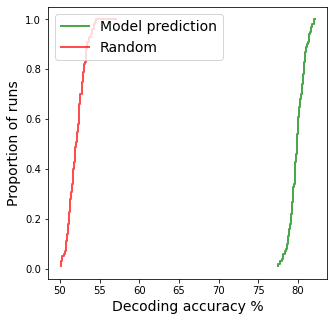

mean decoding accuracy =  79.92111779586946
mean RANDOM decoding accuracy =  52.160924975589516
64555.343755722046


In [38]:
## set SVM params, choose params to classify on, and subset cells ##

#### EDIT THIS ####
filename='TEST'
predict=['Condition'] ## variable to classify (e.g. projection, group, condition)
condition=['All Cells'] ## only used for reference in parameter file
params=np.array(data.columns[10:63]).tolist()## choose params to use for classification 

summarydata=pd.DataFrame(data)
summarydata=summarydata.replace(['mature','immature'],[1,0])
#summarydata=summarydata.replace(['ad lib','fasted'],[0,1])
# label_tag=1  ## Choose 1 for ad lib and 0 for fasted; or 1 for VTA and 0 for LHb ##

# df=summarydata[summarydata.projection == 1]  #change param as input data
df=summarydata

iterations=100
test_data=.2  #defines split for test/train sets
#####

### Run SVM for eYFP+ cells to predict group based on rheo and max latency ###
start = time.time()
ephys_svm(filename,predict,params,iterations,test_data,df)
end = time.time()
print(end - start)